In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install dwave-system
!pip install pandas-datareader --upgrade
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from ast import Return
from itertools import product
import json
import random
import numpy as np
import pandas as pd
import os
import sys
import time
import yaml
#from pandas_datareader.data import DataReader
import datetime as dt
from dimod import Integer, Binary
from dimod import quicksum
from dimod import ConstrainedQuadraticModel, DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler, LeapHybridCQMSampler
from dimod import ExactSolver, ExactCQMSolver
import gc
import matplotlib
import seaborn as sns
from itertools import takewhile, count
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
from IPython.display import clear_output
from typing import NamedTuple
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()


try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

pd.set_option('max_row', None)
pd.set_option('max_column', None)


class SinglePeriod:
    def __init__(
        self, 
        data,  
        preds, 
        budget, 
        init_budget,
        share_budget,
        sampler, 
        sampler_args,
        dates,
        model_type,
        alpha,
        verbose,
        t_cost,
        label,
        init_holdings):
    
        self.df = data
        self.preds = preds
        self.budget = budget
        self.share_budget = share_budget
        self.init_budget = init_budget
        self.dates = dates
        self.model_type = model_type
        self.verbose = verbose
        self.t_cost = t_cost
        self.label = label
        self.stocks = self.df.columns.tolist()
        
        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}
  
        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        self.model = {'CQM': None, 'DQM': None}

        self.sample_set = {}
        if sampler_args:
            self.sampler_args = json.loads(str(sampler_args))
        else:
            self.sampler_args = {}

        self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        #self.sampler = sampler
        self.solution = {}
        self.precision = 2

        self.list_dates = self.df.index.values

    def build_cqm(self, idx, max_risk=None, min_return=None):
        # Instantiating the CQM object
        cqm = ConstrainedQuadraticModel()
        print(f'idx: {idx}')
        #print(f'self.df.loc: {self.df.loc[idx,:]}')
        self.max_num_shares = (self.share_budget/self.df.loc[idx,:]).astype(int)
        #print(f'max_num_shares: {self.max_num_shares}')
        # Defining and adding variables to the CQM model
        x = {s: Integer("%s" %s, lower_bound=0, upper_bound=self.max_num_shares[s]) for s in self.stocks}
        #print(f'x: {x}')
        
        #print(f'self.df')
        #display(self.df.head())
        #print(f'self.df.index.values: {self.df.index.values}')
        #print(f'self.list_dates: {self.list_dates}')
        self.position = np.where(self.list_dates == idx)[0][0]
        print(f'self.position: {self.position}')
        #self.position2 = np.where(self.list_dates == idx)[0]
        #print(f'self.position 2: {self.position2}')
        self.initial_position = self.list_dates[self.position-5]
        print(f'self.initial_position: {self.initial_position}')
        #print('self.df')
        #display(self.df)
        self.price = self.df.loc[idx, :]
        print(f'sum price: {self.price.sum()}')
        #print(f'price: {self.price}')
        #print(self.price)
        self.pct_returns = self.df.pct_change()
        self.daily_returns = self.pct_returns.loc[self.initial_position:idx, :]
        #self.daily_returns = self.pct_returns.loc[self.initial_position:idx, :]
        print(f'sum daily returns: {self.daily_returns.stack().sum()}')
        #self.avg_daily_returns = self.daily_returns.rolling(window=1).mean().loc[idx,:]
        self.avg_daily_returns = self.preds
        print(f'avg daily returns: {self.avg_daily_returns.sum()}')
        # print('avg daily returns 2')
        # display(self.avg_daily_returns2.head())
        self.covariance_matrix = self.daily_returns.cov()
        self.correlation_matrix = self.daily_returns.corr()
        #print('cov matrix')
        #display(self.covariance_matrix.head())
        print(f'covariance_matrix sum: {self.covariance_matrix.stack().sum()}')
        #print('corr matrix')
        #display(self.correlation_matrix.head())
        print(f'correlation_matrix sum: {self.correlation_matrix.stack().sum()}')

        
        # Defining risk expression
        risk = 0
        for s1, s2 in product(self.stocks, self.stocks):
            coeff = (self.covariance_matrix[s1][s2] * self.price[s1] * self.price[s2])
            risk = risk + coeff*x[s1]*x[s2]       
        #print(f'risk: {risk}')

        returns = 0
        for s in self.stocks:
            returns = returns + self.price[s] * self.avg_daily_returns[s] * x[s]
        #print(f'returns: {returns}')

        if not self.t_cost:
            print('t_cost False')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) <= self.budget, label='upper_budget')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) >= 0.997*self.budget, label='lower_budget')
        else:
            print('t_cost True')
            # Modeling transaction cost
            x0 = self.init_holdings
            #print(f'self.init_holdings: {self.init_holdings}')
            # y indicates stock allocations that changed
            y = {s: Binary("Y[%s]" %s) for s in self.stocks}

            lhs = 0

            for s in self.stocks:
                lhs = lhs + 2*self.t_cost*self.price[s]*x[s]*y[s] + self.price[s]*(1 - self.t_cost)*x[s] \
                      - 2*self.t_cost*self.price[s]*x0[s]*y[s] - self.price[s]*(1 - self.t_cost)*x0[s]

            print(f't_cost: {self.t_cost}')
            print(f'upper bound = budget: {self.budget}')
            print(f'init_budget: {self.init_budget}')
            print(f'lower bound: {self.budget - 0.003*self.init_budget}')
            #print(f'lhs: {lhs}')

            cqm.add_constraint(lhs <= self.budget, label='upper_budget')
            cqm.add_constraint(lhs >= self.budget - 0.003*self.init_budget, label='lower_budget')

            # indicator constraints
            for s in self.stocks:
                cqm.add_constraint(x[s] - x0[s]*y[s] >= 0, label=f'indicator_constraint_gte_{s}')
                cqm.add_constraint(x[s] - x[s]*y[s] <= x0[s], label=f'indicator_constraint_lte_{s}')

           
        if max_risk:
            # Adding maximum risk constraint
            cqm.add_constraint(risk <= max_risk, label='max_risk')

            # Objective: maximize return
            cqm.set_objective(-1*returns)
        elif min_return:
            # Adding minimum returns constraint
            cqm.add_constraint(returns >= min_return, label='min_return')

            # Objective: minimize risk
            cqm.set_objective(risk)
        else:
            # Objective: minimize mean-variance expression
            #print('cqm debugging')
            #print(f'risk: {type(risk)}')
            #print(f'returns: {returns}')
            #print(f'objective: {self.alpha*risk - returns}')

            cqm.set_objective(self.alpha*risk - returns)
            #cqm.set_objective(-1*returns)

        cqm.substitute_self_loops()

        self.model['CQM'] = cqm

    def solve_cqm(self, idx, max_risk=None, min_return=None):
        self.build_cqm(idx, max_risk, min_return)

        if self.model_type == 'CQM':
            self.sample_set['CQM'] = self.sampler['CQM'].sample_cqm(self.model['CQM'], label=self.label)
        else:        
            gc.collect()
            self.sample_set['CQM'] = self.sampler['Exact'].sample_cqm(self.model['CQM'])

        n_samples = len(self.sample_set['CQM'].record)
        print(f'n_samples: {n_samples}')
        feasible_samples = self.sample_set['CQM'].filter(lambda d: d.is_feasible)

        if not feasible_samples:
            raise Exception("No feasible solution could be found for this problem instance.")
        else:
            best_feasible = feasible_samples.first

            solution = {}
            solution['stocks'] = {k:int(best_feasible.sample[k]) for k in self.stocks}
            print(f'solution_stocks: {solution["stocks"]}')
            solution['return'], solution['risk'] = self.compute_risk_and_returns(solution['stocks'])
            print(f'solution_return: {solution["return"]}')
            print(f'solution_risk: {solution["risk"]}')
            spending = sum([self.price[s]*max(0, solution['stocks'][s] - self.init_holdings[s]) for s in self.stocks])
            print(f'spending: {spending}')
            sales = sum([self.price[s]*max(0, self.init_holdings[s] - solution['stocks'][s]) for s in self.stocks])
            print(f'sales: {sales}')

            transaction = self.t_cost*(spending + sales)
            print(f'transaction: {transaction}')

            if self.verbose:
                print(f'Number of feasible solutions: {len(feasible_samples)} out of {n_samples} sampled.')
                print(f'\nBest energy: {self.sample_set["CQM"].first.energy: .2f}')
                print(f'Best energy (feasible): {best_feasible.energy: .2f}')

            print(f"\nEstimated Returns: {solution['return']}")
            print(f"Sales Revenue: {sales:.2f}")
            print(f"Purchase Cost: {spending:.2f}")
            print(f"Transaction Cost: {transaction:.2f}")
            print(f"Variance: {solution['risk']}\n")

            #print(f'solution: {solution}')
            return solution


    def compute_risk_and_returns(self, solution):
        """Compute the risk and return values of solution.
        """
        sum_solution = 0
        for s1 in solution:
            #print(f's1: {s1}, {solution[s1]}, price: {self.price[s1]}')
            sum_solution += solution[s1]
            #print(f'covariance matrix: {self.covariance_matrix[s1].sum()}')

        print(f'MMM price: {self.price["MMM"]}, solution: {solution["MMM"]}')
        print(f'sum price: {sum(self.price)}')
        print(f'sum solution: {sum_solution}')

        variance = 0.0
        for s1, s2 in product(solution, solution):
            variance += (solution[s1] * self.price[s1] * solution[s2] * self.price[s2] * self.covariance_matrix[s1][s2])

        est_return = 0
        for stock in solution:
            est_return += solution[stock]*self.price[stock]*self.avg_daily_returns[stock]

        return round(est_return, 2), round(variance, 2)

    def run(self, min_return=0, max_risk=0):

        return self.solve_cqm(min_return=min_return, max_risk=max_risk)

In [4]:
class MultiPeriod():
    """Solve the multi-period (dynamic) portfolio optimization problem.
    """
    def __init__(self, 
                data, 
                baseline,
                budget,
                sampler_args,
                dates,
                file_path,
                model_type,
                alpha,
                verbose,
                t_cost,
                label,
                init_holdings,
                save_path):
    
        self.save_path = save_path
        self.df = data
        self.stocks = self.df.columns.values.tolist()
        self.stocks = sorted(self.stocks)

        
        self.sampler_args = sampler_args
        self.budget = budget
        self.sampler_args = sampler_args
        self.verbose = verbose
        self.label = label
        self.t_cost = t_cost
        self.baseline = baseline
        self.dates = dates
        self.model_type = model_type
        
        initial_gspc = self.baseline.query('Date==@dates[0]').values.tolist()[0][0]
        #print('initial baseline')
        #display(self.baseline)
        #print(f'initial_gspc: {initial_gspc}')
        self.baseline.iloc[:,0] = (self.baseline.iloc[:,0] / initial_gspc - 1)
        self.init_budget = budget
        #print('final baseline')
        #display(self.baseline)
        #print('initial data')
        #display(self.df.head())

        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}

        print('iniital_holdings')
        print(self.init_holdings)
  
        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        self.stocks = list(set(self.df.columns.values.tolist()).intersection(set(self.init_holdings.keys())))
        self.stocks = sorted(self.stocks)
        self.df = self.df.loc[:, self.stocks].copy()
        self.active_data = self.df.loc[dates[0]:,:]
        self.result = pd.DataFrame(columns=self.stocks)

        self.sample_set = {}
        # if sampler_args:
        #     self.sampler_args = json.loads(str(sampler_args))
        # else:
        #     self.sampler_args = {}
        # self.sample_set = {}
        # self.sampler_args = sampler_args
        #self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        self.sampler = {}

        self.solution = {}
        
    def run(self, max_risk=0, min_return=0, num=0):
        """Solve the rebalancing portfolio optimization problem.
        Args:
            max_risk (int): Maximum risk for the CQM risk bounding formulation.
            min_return (int): Minimum return for the CQM return bounding formulation.
        """
        
        num_days = self.active_data.shape[0]
        print(f'num_days: {num_days}')
        first_purchase = True
        #result = {}
        #baseline_result = {}
        #days = []
        
        # dataframe to save output data
        headers = self.stocks
        self.output = pd.DataFrame(columns=headers)
        self.agg_results = pd.DataFrame(columns=['idx', 'variance', 'returns', 'value'])
        #row = []
        

        for idx, row in self.active_data.iterrows():
            print(f'idx: {idx}')
            df_train = self.df.loc[:idx, :]
            #print('df train')
            #display(df_train.head())
            self.preds = predict_returns(df_train)
            self.price = self.df.loc[idx, :]
            baseline_current = self.baseline.loc[idx, :]
            # single_period = SinglePeriod(data=self.df, 
            #                              preds=self.preds.pct_change().iloc[-1,:], 
            #                              budget=self.budget, 
            #                              init_budget = self.init_budget,
            #                              sampler_args=self.sampler_args, 
            #                              dates=self.dates,
            #                              model_type=self.model_type,
            #                              alpha=self.alpha,
            #                              verbose=self.verbose,
            #                              t_cost=self.t_cost,
            #                              label=self.label,
            #                              init_holdings=self.init_holdings)

            if first_purchase:
                print(f'first purchase budget: {self.budget}, initial_budget: {self.init_budget}')
                # single_period = SinglePeriod(data=self.df, 
                #                          preds=self.preds.pct_change().iloc[-1,:], 
                #                          budget=self.budget, 
                #                          init_budget = self.init_budget,
                #                          sampler_args=self.sampler_args, 
                #                          dates=self.dates,
                #                          model_type=self.model_type,
                #                          alpha=self.alpha,
                #                          verbose=self.verbose,
                #                          t_cost=self.t_cost,
                #                          label=self.label,
                #                          init_holdings=self.init_holdings)
                initial_budget = self.budget
                self.share_budget = self.budget
                
                baseline_shares = (self.budget / baseline_current)
                #display(self.baseline)
                #self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
                #self.init_holdings = self.solution['stocks']
                #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            else:
                #self.budget = sum([self.df.iloc[-1][s]*self.solution['stocks'][s] for s in self.stocks])
                self.share_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            # Set budget to 0 to enforce that portfolio is self-financing
                if self.t_cost and not first_purchase:
                    #self.budget = 1
                    self.budget = 0.0
                    #self.budget = self.init_budget
                print(f'new purchase budget: {self.budget}, initial_budget: {self.init_budget}')
                
                
                # if self.t_cost and not first_purchase:
                #     self.budget = 0
            
            single_period = SinglePeriod(data=self.df, 
                                            preds=self.preds.pct_change().iloc[-1,:], 
                                            budget=self.budget, 
                                            init_budget = self.init_budget,
                                            share_budget = self.share_budget,
                                            sampler=self.sampler, 
                                            sampler_args = self.sampler_args,
                                            dates=self.dates,
                                            model_type=self.model_type,
                                            alpha=self.alpha,
                                            verbose=self.verbose,
                                            t_cost=self.t_cost,
                                            label=self.label,
                                            init_holdings=self.init_holdings)
            
            
            #print(f'budget before calculation: {self.budget}, initial_budget: {initial_budget}')
            #print(f'init_holdings before calculation: {self.init_holdings}')
            self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
            self.init_holdings = self.solution['stocks']
            #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'final budget: {sum([self.price[s]*self.solution["stocks"][s] for s in self.stocks])}')
            #print(f'init_holdings after calculation: {self.init_holdings}')

            value = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'value: {value}')
            print(f'sum shares: {sum([self.solution["stocks"][s] for s in self.stocks])}')
            returns = self.solution['return']
            variance = self.solution['risk']

            self.output = pd.concat([self.output, pd.DataFrame([{s: self.solution['stocks'][s] for s in self.stocks}])])
            self.agg_results = pd.concat([self.agg_results, pd.DataFrame([{'idx': idx, 'variance': variance, 'returns': returns, 'value': value}])])
            
            first_purchase = False

            #clear_output(wait=True)
            initial_budget = self.agg_results['value'].values.tolist()[0]
            self.agg_results['value_norm'] = self.agg_results['value'] / initial_budget - 1
            display(self.agg_results)
            
            fig = plt.figure(figsize=(10.708,8.2))
            sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
            sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
            plt.show()
            print(f'\nRun completed.\n')

            self.output.to_pickle(self.save_path+'output.pkl')
            self.agg_results.to_pickle(self.save_path+'agg_results.pkl')
            self.baseline.to_pickle(self.save_path+'baseline.pkl')

        return None

In [5]:
def load_data(initial_date, dates, stocks, baseline):
    print(f"\nLoading live data from the web from Yahoo! finance", f"from {initial_date} to {dates[1]}...")

    # Read in daily data; resample to monthly
    print(f'reader initial date: {initial_date}')
    print(f'reader final_date: {dates[1]}')
    print(f'stocks: {stocks}')
    #panel_data = DataReader(stocks, 'yahoo', initial_date, dates[1])
    panel_data = pdr.get_data_yahoo(stocks, start=initial_date, end=dates[1])
    df = pd.DataFrame(index=panel_data.index, columns=stocks)
    
    for i in stocks:
        df[i] = panel_data[[('Adj Close',  i)]]
    df.dropna(axis=1, inplace=True)
    df.reset_index(inplace=True)
    df['Date_tmp'] = df['Date'].map(lambda x: str(x)[:10])
    df.drop('Date', inplace=True, axis=1)
    df.rename(columns={'Date_tmp': 'Date'}, inplace=True)
    df.set_index('Date', inplace=True)
    display(df.head())

    # Read in baseline data; resample to monthly
    #index_df = DataReader(baseline, 'yahoo', dates[0], dates[1])
    index_df = pdr.get_data_yahoo(baseline, start=dates[0], end=dates[1])
    df_baseline = index_df['Adj Close'].to_frame().rename(columns={'Adj Close': '^GSPC'})
    df_baseline.reset_index(inplace=True)
    df_baseline['Date_tmp'] = df_baseline['Date'].map(lambda x: str(x)[:10])
    df_baseline.drop('Date', inplace=True, axis=1)
    df_baseline.rename(columns={'Date_tmp': 'Date'}, inplace=True)
    df_baseline.set_index('Date', inplace=True)
    display(df_baseline.head())
    #df_baseline = pd.DataFrame(index=index_df.index, columns=['Adj Close'])
    #for i in baseline:
    #    df_baseline[i] = index_df[[('Adj Close',  i)]]

    return df, df_baseline

In [6]:
def predict_returns(df):
    result = {}
    df = df.copy()

    for i, column in enumerate(df.columns.values):
        train = df.loc[:, column]
        history = [x for x in train.values]
        pred = list()
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        result[column] = output[0]

    pred_df = pd.DataFrame([result])
    return pd.concat([df, pred_df])

In [7]:
# GA block
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if np.random.rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = np.random.randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        if np.random.rand() < r_mut:
            inverse_s = ''

            for b in bitstring[i]:  
                if b == '0':
                    inverse_s += '1'       
                else:
                    inverse_s += '0'
            bitstring[i] = inverse_s
    return bitstring

def selection(pop, scores, k=3):
	# first random selection
	selection_ix = np.random.randint(len(pop))
	#print(selection_ix)
	for ix in np.random.randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	#print(f'selection ix: {selection_ix}')
	return pop[selection_ix]

def objective(x, daily_return):
    offset = 0
    #offset = 1000 if any([y<0 for y in x]) else 0
    return -1 * sum([d1 * d2 for d1,d2 in zip(x, list(daily_return))]) + offset

def sample_initial_pop(prices, n_pop, budget):
    pop = []
    total = 0
    #shares = np.random.randint(100, size=len(prices))
    score_report = []
    for i in range(n_pop):
        while True:
            factor = np.random.randint(10, size=1)
            shares = [int(factor[0] * i) for i in np.random.chisquare(1,len(prices))]
            #print(f'len shares: {len(shares)}')
            #print(f'len prices: {len(prices)}')
            #print(f'shares: {shares}')
            #print(f'prices: {prices}')
            #print('list zip')
            #print([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            total = sum([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            if total <= budget and total > 0.9 * budget: break
        score_report.append(total)
        pop.append(shares)
    pop = np.array(pop)
    fig, ax = plt.subplots(figsize=(12, 8)) 
    ax.hist(score_report) 
    ax.set_title('scores')
    plt.show()
    return pop


def generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget):
    prices = df.iloc[0, :].values.tolist()
    #print(f'prices: {prices}')
    pop = sample_initial_pop(prices, n_pop, budget)
    daily_return = df.pct_change().iloc[-1, :].values
    # keep track of best solution
    best, best_eval, best_total = 0, objective(pop[0], daily_return), 0   
    # enumerate generations
    for gen in range(n_iter):
        # evaluate all candidates in the population
        scores = [objective(c, daily_return) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best_total = sum([d1 * d2 for d1, d2 in zip(prices, pop[i])])
                best, best_eval  = pop[i], scores[i]
    
        selected = [selection(pop, scores).tolist() for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
        # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
        # crossover and mutation
            for c in crossover(p1, p2, r_cross): #.block_until_ready():
                # mutation
                m = mutation(["{0:b}".format(i) for i in c], r_mut)
                cm = [int(i, 2) for i in m]
                children.append(cm)

        # replace population
        pop = np.array(children)
        total = sum([d1 * d2 for d1, d2 in zip(prices, scores)])
        if gen % 10 == 0:
            total = np.dot(np.array(prices), np.array(pop).T)
            clear_output(wait=True)
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8)) 
            ax[0].hist(scores) 
            ax[0].set_title('scores')
            ax[1].hist(total)
            ax[1].set_title('budget')
            plt.show()
            print(f'{gen} best eval:{best_eval}')
            print(f'mean score: {np.mean(scores)}')
            print(f'best total: {best_total}')

    print(f'best: {best}')
    print(f'best_eval: {best_eval}')
    print(f'best_total: {best_total}')
    names = df.columns.tolist()
    df = pd.DataFrame([[i,j] for i,j in zip(names, best)], columns=['a', 'b'])
    return df, best_total

In [8]:
load_path = '/content/drive/MyDrive/dwave/conf/'
pickle_file = '/content/drive/MyDrive/ga/df.pkl'
with open(load_path+'config.txt', 'r') as conf:
    cred = conf.readline().strip()

cfg = {'stocks': None,
            'dates': ["2021-06-01", "2021-07-01"],
            'initial_date': "2021-01-01",
            'budget': 1000000,
            'bin_size': '',
            'gamma': '',
            'alpha': 0.05,
            'file_path': None,
            'baseline': ['^GSPC'],
            'max_risk': 0.0,
            'min_return': 0.0,
            'model_type': 'CQM',
            'rebalance': True,
            'sampler_args': cred,
            'verbose': False,
            'num': 0,
            't_cost': 0.001,
            'n_iter': 10000,
            'r_cross': 0.8,
            'r_mut': 0.01,
            'n_pop': 1000,
            'label': 'RunTest2',
            'init_holdings_path': '/content/drive/MyDrive/dwave/init_holdings.pkl',
            'calculation_type': 'daily',
            'save_path': '/content/drive/MyDrive/dwave/'
}
locals().update(cfg)

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
stocks = first_table['Symbol'].values.tolist()
#stocks = ['MMM', 'GOOG', 'AAP']
#print(f'stocks: {stocks}')
stocks = sorted(stocks)
print(f'stocks: {stocks}')

df, df_baseline = load_data(initial_date, dates, stocks, baseline)



stocks: ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF.B', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BRK.B', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISH', 'DLR'

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STLD,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,117.230377,15.13,149.533569,127.874939,95.901825,93.868271,105.199562,34.900002,248.901123,485.339996,140.956879,47.784592,162.713135,296.839996,72.225693,76.104866,21.922611,41.079163,35.418663,127.535362,117.237526,105.239998,150.416687,526.460022,49.240002,102.511505,111.874298,85.464363,10.508929,92.300003,116.865349,213.126602,181.814941,209.839798,159.331497,70.790001,357.670013,201.070221,51.779243,14.356004,255.987839,62.983284,129.509995,161.739456,89.336777,88.938156,146.124390,400.089966,147.571701,145.578003,114.787933,1180.400024,202.720001,28.792398,87.994331,77.651901,31.166666,93.737274,237.989151,22.429255,242.949997,575.260010,39.047569,2164.080078,19.856245,677.771057,57.706631,146.538147,45.614170,35.270000,36.872478,83.737488,56.102676,33.239017,49.498528,36.042698,173.497498,144.735306,92.610001,59.500000,145.001877,20.379999,102.529999,135.759995,124.464455,120.861877,37.047531,32.625393,84.571358,87.981606,647.030029,198.795105,80.666695,79.994736,188.075684,51.644150,47.963367,165.891327,1319.119995,210.551895,56.297634,62.090000,20.303865,94.209000,357.113647,36.444530,374.112549,45.213501,60.325001,91.374405,249.669998,220.309998,41.412868,89.526001,28.646784,337.010864,103.730003,14.343384,77.226616,37.522797,66.294937,77.692520,71.599998,68.902245,38.730000,67.868332,261.473297,86.306908,206.176743,116.106361,65.974350,221.700470,177.679993,31.530001,126.137062,1

[*********************100%***********************]  1 of 1 completed


,^GSPC
Date,
2021-06-01,4202.040039
2021-06-02,4208.120117
2021-06-03,4192.850098
2021-06-04,4229.890137
2021-06-07,4226.520020


initial df


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STLD,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,117.230377,15.13,149.533569,127.874939,95.901825,93.868271,105.199562,34.900002,248.901123,485.339996,140.956879,47.784592,162.713135,296.839996,72.225693,76.104866,21.922611,41.079163,35.418663,127.535362,117.237526,105.239998,150.416687,526.460022,49.240002,102.511505,111.874298,85.464363,10.508929,92.300003,116.865349,213.126602,181.814941,209.839798,159.331497,70.790001,357.670013,201.070221,51.779243,14.356004,255.987839,62.983284,129.509995,161.739456,89.336777,88.938156,146.124390,400.089966,147.571701,145.578003,114.787933,1180.400024,202.720001,28.792398,87.994331,77.651901,31.166666,93.737274,237.989151,22.429255,242.949997,575.260010,39.047569,2164.080078,19.856245,677.771057,57.706631,146.538147,45.614170,35.270000,36.872478,83.737488,56.102676,33.239017,49.498528,36.042698,173.497498,144.735306,92.610001,59.500000,145.001877,20.379999,102.529999,135.759995,124.464455,120.861877,37.047531,32.625393,84.571358,87.981606,647.030029,198.795105,80.666695,79.994736,188.075684,51.644150,47.963367,165.891327,1319.119995,210.551895,56.297634,62.090000,20.303865,94.209000,357.113647,36.444530,374.112549,45.213501,60.325001,91.374405,249.669998,220.309998,41.412868,89.526001,28.646784,337.010864,103.730003,14.343384,77.226616,37.522797,66.294937,77.692520,71.599998,68.902245,38.730000,67.868332,261.473297,86.306908,206.176743,116.106361,65.974350,221.700470,177.679993,31.530001,126.137062,1

iniital_holdings
{'A': 0, 'AAL': 0, 'AAP': 0, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABT': 0, 'ACGL': 0, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 0, 'ADP': 0, 'ADSK': 0, 'AEE': 0, 'AEP': 0, 'AES': 0, 'AFL': 0, 'AIG': 0, 'AIZ': 0, 'AJG': 0, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 0, 'ALLE': 0, 'AMAT': 0, 'AMCR': 0, 'AMD': 0, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 0, 'ANSS': 0, 'AON': 0, 'AOS': 0, 'APA': 0, 'APD': 0, 'APH': 0, 'APTV': 0, 'ARE': 0, 'ATO': 0, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 0, 'AWK': 0, 'AXP': 0, 'AZO': 0, 'BA': 0, 'BAC': 0, 'BALL': 0, 'BAX': 0, 'BBWI': 0, 'BBY': 0, 'BDX': 0, 'BEN': 0, 'BF.B': 0, 'BIIB': 0, 'BIO': 0, 'BK': 0, 'BKNG': 0, 'BKR': 0, 'BLK': 0, 'BMY': 0, 'BR': 0, 'BRK.B': 0, 'BRO': 0, 'BSX': 0, 'BWA': 0, 'BXP': 0, 'C': 0, 'CAG': 0, 'CAH': 0, 'CARR': 0, 'CAT': 0, 'CB': 0, 'CBOE': 0, 'CBRE': 0, 'CCI': 0, 'CCL': 0, 'CDAY': 0, 'CDNS': 0, 'CDW': 0, 'CE': 0, 'CEG': 0, 'CF': 0, 'CFG': 0, 'CHD': 0, 'CHRW': 0, 'CHTR': 0, 'CI': 0, 'CINF': 0, '

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


first purchase budget: 1000000, initial_budget: 1000000
idx: 2021-06-01
self.position: 102
self.initial_position: 2021-05-24
sum price: 85033.20945835114
sum daily returns: 7.819663904674166
avg daily returns: -0.4182470875351554
covariance_matrix sum: 3.925501793055037
correlation_matrix sum: 27588.638281416912
t_cost True
t_cost: 0.001
upper bound = budget: 1000000
init_budget: 1000000
lower bound: 997000.0
n_samples: 83
solution_stocks: {'A': 0, 'AAL': 3, 'AAP': 36, 'AAPL': 23, 'ABBV': 30, 'ABC': 42, 'ABT': 13, 'ACGL': 1, 'ACN': 30, 'ADBE': 0, 'ADI': 6, 'ADM': 106, 'ADP': 0, 'ADSK': 7, 'AEE': 30, 'AEP': 16, 'AES': 115, 'AFL': 1, 'AIG': 0, 'AIZ': 15, 'AJG': 0, 'AKAM': 14, 'ALB': 0, 'ALGN': 0, 'ALK': 23, 'ALL': 10, 'ALLE': 13, 'AMAT': 5, 'AMCR': 142, 'AMD': 70, 'AME': 15, 'AMGN': 5, 'AMP': 0, 'AMT': 0, 'AMZN': 16, 'ANET': 17, 'ANSS': 0, 'AON': 0, 'AOS': 54, 'APA': 0, 'APD': 20, 'APH': 21, 'APTV': 0, 'ARE': 0, 'ATO': 1, 'ATVI': 22, 'AVB': 29, 'AVGO': 4, 'AVY': 0, 'AWK': 20, 'AXP': 0, '

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,998995.182866,0.0


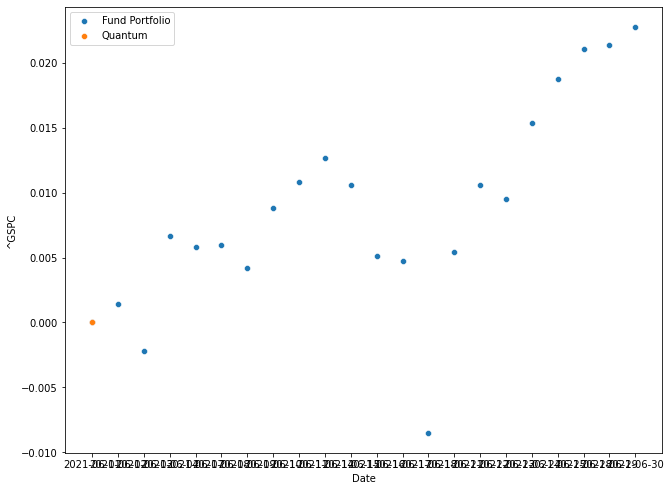


Run completed.

idx: 2021-06-02
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-02
self.position: 103
self.initial_position: 2021-05-25
sum price: 84972.81925868988
sum daily returns: 5.174048799488546
avg daily returns: 0.09581596125090874
covariance_matrix sum: 3.1045325597636375
correlation_matrix sum: 16948.534964791972
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 81
solution_stocks: {'A': 8, 'AAL': 37, 'AAP': 10, 'AAPL': 13, 'ABBV': 39, 'ABC': 0, 'ABT': 89, 'ACGL': 83, 'ACN': 7, 'ADBE': 9, 'ADI': 1, 'ADM': 8, 'ADP': 11, 'ADSK': 6, 'AEE': 16, 'AEP': 23, 'AES': 202, 'AFL': 1, 'AIG': 30, 'AIZ': 0, 'AJG': 32, 'AKAM': 64, 'ALB': 0, 'ALGN': 0, 'ALK': 11, 'ALL': 10, 'ALLE': 1, 'AMAT': 78, 'AMCR': 175, 'AMD': 26, 'AME': 47, 'AMGN': 14, 'AMP': 0, 'AMT': 5, 'AMZN': 3, 'ANET': 27, 'ANSS': 6, 'AON': 10, 'AOS': 85, 'APA': 49, 'APD': 1, 'APH': 10, 'APTV': 0, 'ARE': 13, 'ATO': 21, 'ATVI': 29, 'AVB': 7, 'AVGO': 0, 'AVY': 

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,998995.182866,0.000000
0,2021-06-02,188.31,-42.04,998517.718469,-0.000478


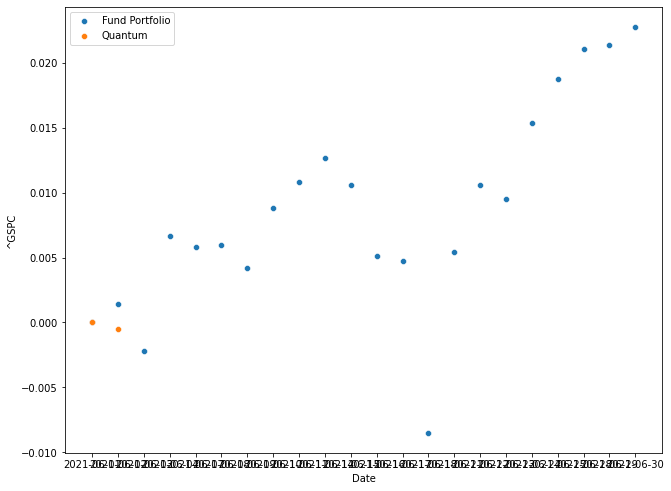


Run completed.

idx: 2021-06-03
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-03
self.position: 104
self.initial_position: 2021-05-26
sum price: 84630.21082496643
sum daily returns: 6.611206251378441
avg daily returns: 0.43721366577446985
covariance_matrix sum: 1.594581901561899
correlation_matrix sum: 7577.035369097355
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 75
solution_stocks: {'A': 16, 'AAL': 9, 'AAP': 0, 'AAPL': 1, 'ABBV': 0, 'ABC': 2, 'ABT': 1182, 'ACGL': 27, 'ACN': 0, 'ADBE': 0, 'ADI': 1, 'ADM': 0, 'ADP': 11, 'ADSK': 0, 'AEE': 12, 'AEP': 3, 'AES': 0, 'AFL': 2, 'AIG': 40, 'AIZ': 0, 'AJG': 0, 'AKAM': 13, 'ALB': 34, 'ALGN': 0, 'ALK': 29, 'ALL': 1, 'ALLE': 3, 'AMAT': 66, 'AMCR': 169, 'AMD': 3, 'AME': 5, 'AMGN': 2, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 0, 'ANSS': 0, 'AON': 0, 'AOS': 61, 'APA': 6, 'APD': 7, 'APH': 3, 'APTV': 200, 'ARE': 0, 'ATO': 0, 'ATVI': 0, 'AVB': 0, 'AVGO': 11, 'AVY': 2, 'AWK': 0, '

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,998995.182866,0.000000
0,2021-06-02,188.31,-42.04,998517.718469,-0.000478
0,2021-06-03,147.44,1735.07,995578.393116,-0.003420


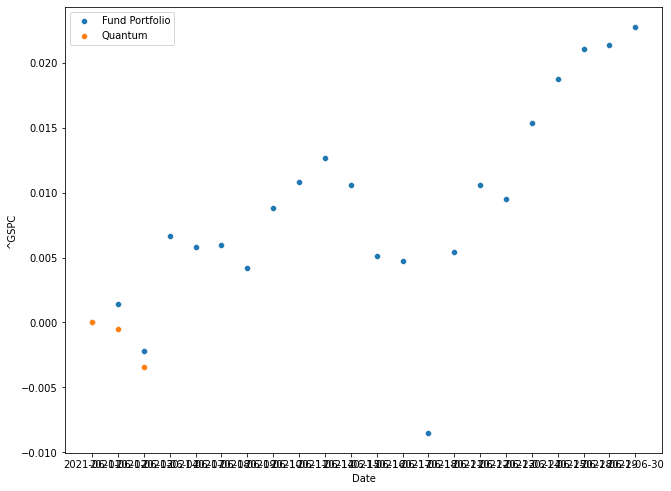


Run completed.

idx: 2021-06-04
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-04
self.position: 105
self.initial_position: 2021-05-27
sum price: 85246.77898025513
sum daily returns: 7.35559552711193
avg daily returns: -0.32391918073494197
covariance_matrix sum: 1.9660393266981595
correlation_matrix sum: 10544.671424080809
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 93
solution_stocks: {'A': 0, 'AAL': 206, 'AAP': 16, 'AAPL': 0, 'ABBV': 0, 'ABC': 8, 'ABT': 80, 'ACGL': 17, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 12, 'ADP': 0, 'ADSK': 0, 'AEE': 53, 'AEP': 7, 'AES': 1, 'AFL': 26, 'AIG': 4, 'AIZ': 0, 'AJG': 0, 'AKAM': 27, 'ALB': 24, 'ALGN': 1, 'ALK': 1, 'ALL': 0, 'ALLE': 29, 'AMAT': 0, 'AMCR': 174, 'AMD': 0, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 1, 'AMZN': 0, 'ANET': 0, 'ANSS': 0, 'AON': 0, 'AOS': 44, 'APA': 121, 'APD': 0, 'APH': 4, 'APTV': 52, 'ARE': 7, 'ATO': 22, 'ATVI': 24, 'AVB': 5, 'AVGO': 0, 'AVY': 1, 'AWK': 0

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537


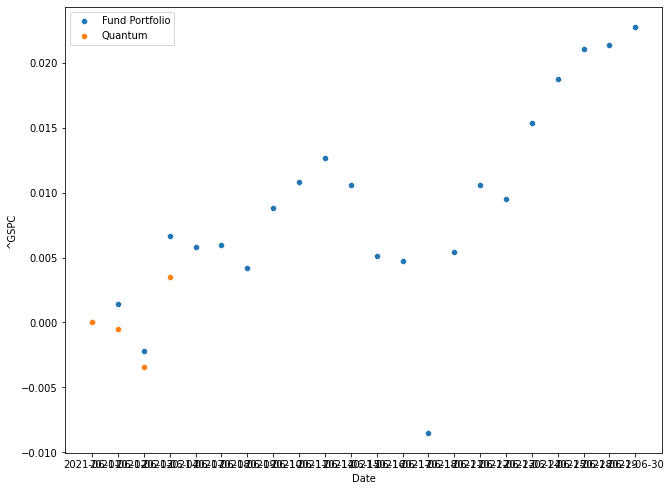


Run completed.

idx: 2021-06-07
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-07
self.position: 106
self.initial_position: 2021-05-28
sum price: 85081.95863246918
sum daily returns: 3.9844553710955837
avg daily returns: 0.6934372163582809
covariance_matrix sum: 2.157148342056588
correlation_matrix sum: 17195.275411769693
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 88
solution_stocks: {'A': 0, 'AAL': 62, 'AAP': 0, 'AAPL': 1, 'ABBV': 19, 'ABC': 23, 'ABT': 55, 'ACGL': 11, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 15, 'ADP': 0, 'ADSK': 0, 'AEE': 27, 'AEP': 51, 'AES': 40, 'AFL': 87, 'AIG': 21, 'AIZ': 14, 'AJG': 7, 'AKAM': 100, 'ALB': 0, 'ALGN': 0, 'ALK': 10, 'ALL': 10, 'ALLE': 20, 'AMAT': 12, 'AMCR': 89, 'AMD': 34, 'AME': 2, 'AMGN': 17, 'AMP': 0, 'AMT': 3, 'AMZN': 0, 'ANET': 36, 'ANSS': 0, 'AON': 0, 'AOS': 0, 'APA': 17, 'APD': 2, 'APH': 48, 'APTV': 21, 'ARE': 7, 'ATO': 8, 'ATVI': 0, 'AVB': 2, 'AVGO': 0, 'AVY': 0, 'AW

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373


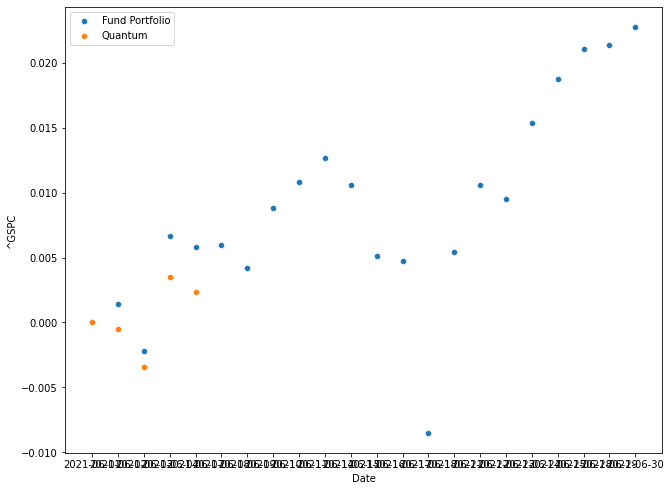


Run completed.

idx: 2021-06-08


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-08
self.position: 107
self.initial_position: 2021-06-01
sum price: 85325.17257881165
sum daily returns: 4.256408580109076
avg daily returns: 0.12832370831711437
covariance_matrix sum: 2.1673233123441005
correlation_matrix sum: 16290.925332298284
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 80
solution_stocks: {'A': 0, 'AAL': 5, 'AAP': 0, 'AAPL': 42, 'ABBV': 11, 'ABC': 48, 'ABT': 44, 'ACGL': 64, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 40, 'ADP': 0, 'ADSK': 0, 'AEE': 11, 'AEP': 10, 'AES': 35, 'AFL': 5, 'AIG': 11, 'AIZ': 2, 'AJG': 2, 'AKAM': 20, 'ALB': 0, 'ALGN': 0, 'ALK': 30, 'ALL': 9, 'ALLE': 62, 'AMAT': 0, 'AMCR': 250, 'AMD': 1, 'AME': 22, 'AMGN': 0, 'AMP': 2, 'AMT': 16, 'AMZN': 0, 'ANET': 72, 'ANSS': 0, 'AON': 1, 'AOS': 20, 'APA': 111, 'APD': 11, 'APH': 62, 'APTV': 8, 'ARE': 6, 'ATO': 5, 'ATVI': 0, 'AVB': 8, 'AVGO': 0, 'AVY': 0, 'AWK': 24, 'AXP': 8, 'AZO': 0, 'BA': 

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738


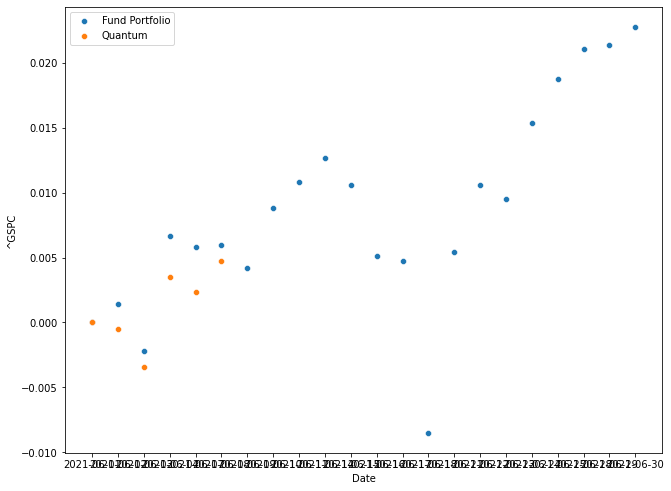


Run completed.

idx: 2021-06-09
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-09
self.position: 108
self.initial_position: 2021-06-02
sum price: 85033.7906036377
sum daily returns: 0.3033375326123333
avg daily returns: 0.33674330738398983
covariance_matrix sum: 3.001463791925891
correlation_matrix sum: 23825.463199730744
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 78
solution_stocks: {'A': 8, 'AAL': 62, 'AAP': 0, 'AAPL': 14, 'ABBV': 6, 'ABC': 0, 'ABT': 21, 'ACGL': 0, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 0, 'ADP': 8, 'ADSK': 0, 'AEE': 16, 'AEP': 93, 'AES': 21, 'AFL': 25, 'AIG': 10, 'AIZ': 2, 'AJG': 25, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 0, 'ALLE': 0, 'AMAT': 0, 'AMCR': 64, 'AMD': 0, 'AME': 0, 'AMGN': 19, 'AMP': 0, 'AMT': 0, 'AMZN': 7, 'ANET': 52, 'ANSS': 0, 'AON': 38, 'AOS': 60, 'APA': 40, 'APD': 4, 'APH': 68, 'APTV': 0, 'ARE': 6, 'ATO': 8, 'ATVI': 0, 'AVB': 24, 'AVGO': 16, 'AVY': 11, 'AWK': 17

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163


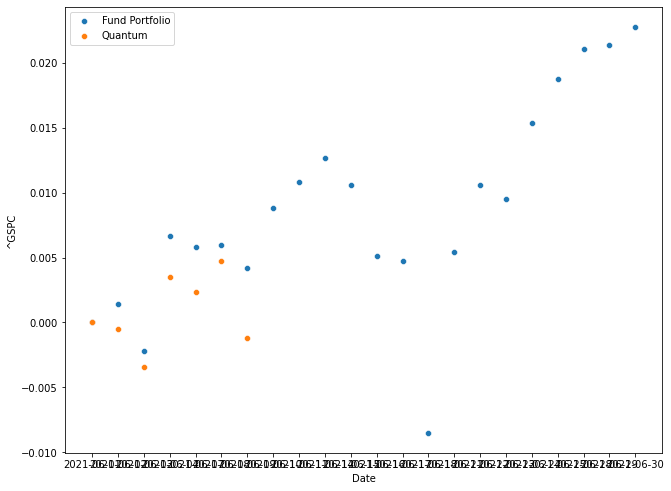


Run completed.

idx: 2021-06-10
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-10
self.position: 109
self.initial_position: 2021-06-03
sum price: 85237.58198070526
sum daily returns: 0.6640049986010969
avg daily returns: -0.05940801795919315
covariance_matrix sum: 3.0931464199910796
correlation_matrix sum: 24776.535789874495
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 84
solution_stocks: {'A': 7, 'AAL': 5, 'AAP': 54, 'AAPL': 0, 'ABBV': 39, 'ABC': 0, 'ABT': 20, 'ACGL': 0, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 22, 'ADP': 0, 'ADSK': 0, 'AEE': 65, 'AEP': 68, 'AES': 26, 'AFL': 30, 'AIG': 34, 'AIZ': 9, 'AJG': 22, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 5, 'ALLE': 3, 'AMAT': 0, 'AMCR': 28, 'AMD': 0, 'AME': 1, 'AMGN': 54, 'AMP': 1, 'AMT': 0, 'AMZN': 0, 'ANET': 34, 'ANSS': 0, 'AON': 38, 'AOS': 80, 'APA': 5, 'APD': 0, 'APH': 25, 'APTV': 2, 'ARE': 0, 'ATO': 11, 'ATVI': 0, 'AVB': 24, 'AVGO': 0, 'AVY': 4, 'AWK': 

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423


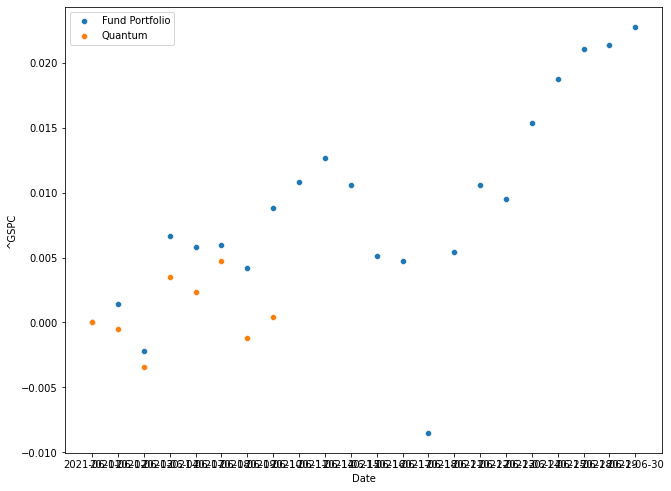


Run completed.

idx: 2021-06-11
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-11
self.position: 110
self.initial_position: 2021-06-04
sum price: 85556.64577388763
sum daily returns: 3.313126803120487
avg daily returns: -0.13345054540574808
covariance_matrix sum: 3.164343698997022
correlation_matrix sum: 30001.781246563714
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 81
solution_stocks: {'A': 12, 'AAL': 151, 'AAP': 0, 'AAPL': 0, 'ABBV': 31, 'ABC': 0, 'ABT': 4, 'ACGL': 48, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 61, 'ADP': 0, 'ADSK': 0, 'AEE': 21, 'AEP': 41, 'AES': 105, 'AFL': 10, 'AIG': 30, 'AIZ': 14, 'AJG': 3, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 17, 'ALL': 16, 'ALLE': 0, 'AMAT': 10, 'AMCR': 11, 'AMD': 0, 'AME': 0, 'AMGN': 13, 'AMP': 0, 'AMT': 0, 'AMZN': 2, 'ANET': 13, 'ANSS': 0, 'AON': 20, 'AOS': 30, 'APA': 79, 'APD': 0, 'APH': 8, 'APTV': 20, 'ARE': 6, 'ATO': 22, 'ATVI': 0, 'AVB': 1, 'AVGO': 0, 'AVY': 12, 'A

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423
0,2021-06-11,15347.22,-707.86,9.989337e+05,-0.000062


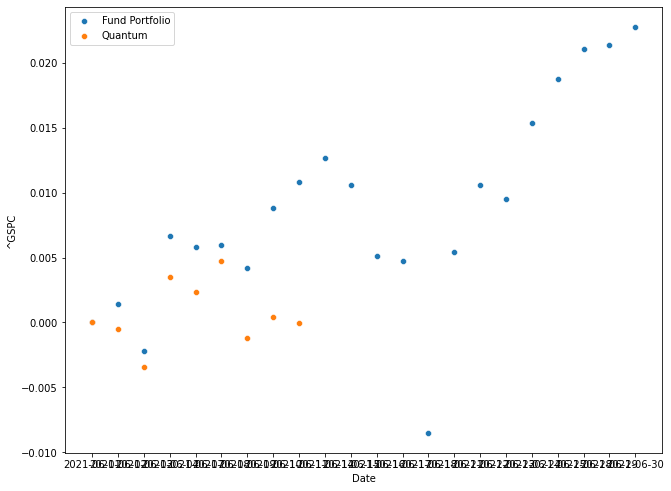


Run completed.

idx: 2021-06-14
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-14
self.position: 111
self.initial_position: 2021-06-07
sum price: 85568.66140079498
sum daily returns: -1.315256108503593
avg daily returns: 0.06407929959538095
covariance_matrix sum: 2.603498089227493
correlation_matrix sum: 25286.461392222533
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 92
solution_stocks: {'A': 0, 'AAL': 14, 'AAP': 24, 'AAPL': 69, 'ABBV': 35, 'ABC': 0, 'ABT': 78, 'ACGL': 18, 'ACN': 8, 'ADBE': 0, 'ADI': 29, 'ADM': 0, 'ADP': 0, 'ADSK': 0, 'AEE': 13, 'AEP': 14, 'AES': 112, 'AFL': 31, 'AIG': 17, 'AIZ': 8, 'AJG': 38, 'AKAM': 0, 'ALB': 14, 'ALGN': 0, 'ALK': 34, 'ALL': 4, 'ALLE': 0, 'AMAT': 0, 'AMCR': 24, 'AMD': 0, 'AME': 13, 'AMGN': 0, 'AMP': 0, 'AMT': 25, 'AMZN': 1, 'ANET': 0, 'ANSS': 0, 'AON': 6, 'AOS': 25, 'APA': 122, 'APD': 0, 'APH': 17, 'APTV': 8, 'ARE': 0, 'ATO': 7, 'ATVI': 4, 'AVB': 0, 'AVGO': 15, 'AVY': 26, 'A

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423
0,2021-06-11,15347.22,-707.86,9.989337e+05,-0.000062
0,2021-06-14,9623.83,537.38,9.949905e+05,-0.004009


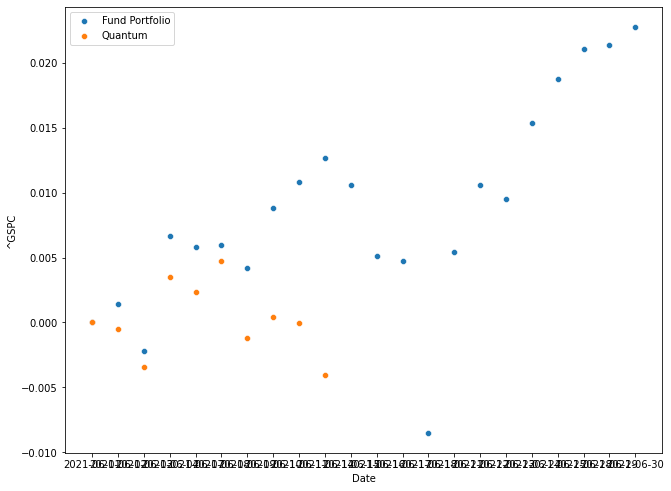


Run completed.

idx: 2021-06-15
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-15
self.position: 112
self.initial_position: 2021-06-08
sum price: 85548.78478813171
sum daily returns: -0.379836331563692
avg daily returns: -0.08632767976822242
covariance_matrix sum: 2.501229557102685
correlation_matrix sum: 19824.751493537355
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 83
solution_stocks: {'A': 6, 'AAL': 36, 'AAP': 8, 'AAPL': 61, 'ABBV': 0, 'ABC': 0, 'ABT': 13, 'ACGL': 7, 'ACN': 6, 'ADBE': 0, 'ADI': 4, 'ADM': 79, 'ADP': 1, 'ADSK': 0, 'AEE': 10, 'AEP': 54, 'AES': 11, 'AFL': 22, 'AIG': 8, 'AIZ': 5, 'AJG': 11, 'AKAM': 1, 'ALB': 16, 'ALGN': 0, 'ALK': 8, 'ALL': 31, 'ALLE': 0, 'AMAT': 40, 'AMCR': 402, 'AMD': 0, 'AME': 8, 'AMGN': 0, 'AMP': 1, 'AMT': 0, 'AMZN': 0, 'ANET': 0, 'ANSS': 0, 'AON': 6, 'AOS': 50, 'APA': 158, 'APD': 9, 'APH': 18, 'APTV': 6, 'ARE': 1, 'ATO': 5, 'ATVI': 12, 'AVB': 9, 'AVGO': 0, 'AVY': 27, 'AWK':

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423
0,2021-06-11,15347.22,-707.86,9.989337e+05,-0.000062
0,2021-06-14,9623.83,537.38,9.949905e+05,-0.004009


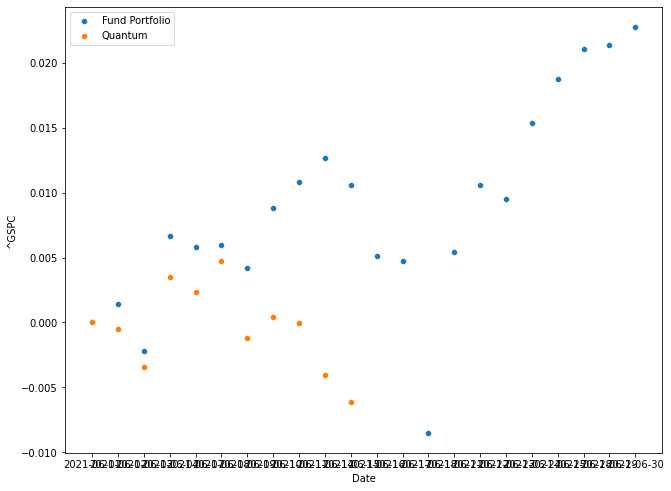


Run completed.

idx: 2021-06-16
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-16
self.position: 113
self.initial_position: 2021-06-09
sum price: 85020.46933364868
sum daily returns: -4.522983657042795
avg daily returns: -0.18077846060224545
covariance_matrix sum: 3.7387943339422853
correlation_matrix sum: 35927.78730730662
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 81
solution_stocks: {'A': 8, 'AAL': 46, 'AAP': 16, 'AAPL': 47, 'ABBV': 0, 'ABC': 0, 'ABT': 10, 'ACGL': 7, 'ACN': 0, 'ADBE': 0, 'ADI': 21, 'ADM': 10, 'ADP': 0, 'ADSK': 0, 'AEE': 5, 'AEP': 16, 'AES': 102, 'AFL': 8, 'AIG': 7, 'AIZ': 5, 'AJG': 1, 'AKAM': 0, 'ALB': 29, 'ALGN': 0, 'ALK': 9, 'ALL': 40, 'ALLE': 6, 'AMAT': 1, 'AMCR': 42, 'AMD': 0, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 11, 'ANSS': 0, 'AON': 0, 'AOS': 1, 'APA': 24, 'APD': 0, 'APH': 55, 'APTV': 27, 'ARE': 29, 'ATO': 33, 'ATVI': 15, 'AVB': 0, 'AVGO': 16, 'AVY': 0, 'AWK':

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423
0,2021-06-11,15347.22,-707.86,9.989337e+05,-0.000062
0,2021-06-14,9623.83,537.38,9.949905e+05,-0.004009


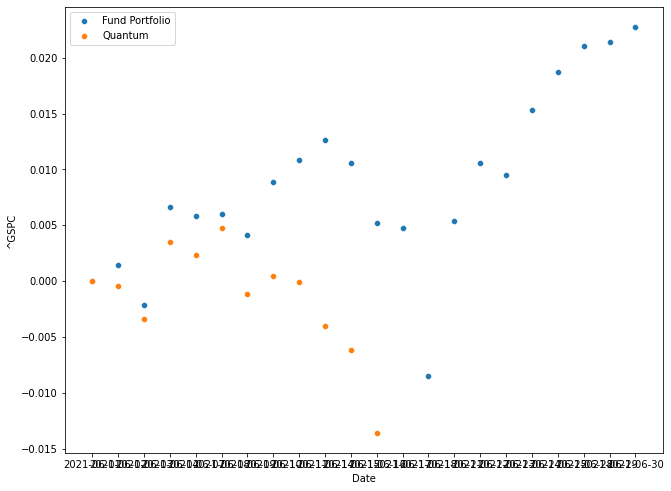


Run completed.

idx: 2021-06-17
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-17
self.position: 114
self.initial_position: 2021-06-10
sum price: 84928.54124832153
sum daily returns: -7.1060206177110254
avg daily returns: 0.5143206710872219
covariance_matrix sum: 6.266573255286089
correlation_matrix sum: 37182.21943207584
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 81
solution_stocks: {'A': 0, 'AAL': 87, 'AAP': 0, 'AAPL': 5, 'ABBV': 0, 'ABC': 0, 'ABT': 15, 'ACGL': 5, 'ACN': 0, 'ADBE': 0, 'ADI': 3, 'ADM': 12, 'ADP': 0, 'ADSK': 0, 'AEE': 4, 'AEP': 12, 'AES': 130, 'AFL': 2, 'AIG': 19, 'AIZ': 0, 'AJG': 0, 'AKAM': 0, 'ALB': 29, 'ALGN': 0, 'ALK': 54, 'ALL': 0, 'ALLE': 0, 'AMAT': 0, 'AMCR': 93, 'AMD': 0, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 8, 'ANET': 9, 'ANSS': 0, 'AON': 0, 'AOS': 0, 'APA': 122, 'APD': 0, 'APH': 16, 'APTV': 0, 'ARE': 0, 'ATO': 29, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 0, 'AWK': 0, 'AXP

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423
0,2021-06-11,15347.22,-707.86,9.989337e+05,-0.000062
0,2021-06-14,9623.83,537.38,9.949905e+05,-0.004009


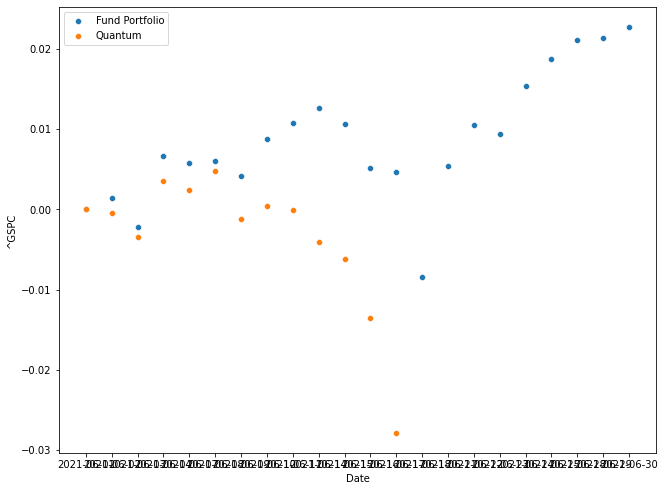


Run completed.

idx: 2021-06-18
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-18
self.position: 115
self.initial_position: 2021-06-11
sum price: 83972.47080612183
sum daily returns: -16.288346890436202
avg daily returns: -0.16002047551441334
covariance_matrix sum: 12.676499069346535
correlation_matrix sum: 61439.76980202003
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 75
solution_stocks: {'A': 0, 'AAL': 101, 'AAP': 0, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABT': 3, 'ACGL': 0, 'ACN': 0, 'ADBE': 11, 'ADI': 0, 'ADM': 20, 'ADP': 0, 'ADSK': 32, 'AEE': 0, 'AEP': 38, 'AES': 44, 'AFL': 4, 'AIG': 3, 'AIZ': 0, 'AJG': 0, 'AKAM': 55, 'ALB': 0, 'ALGN': 0, 'ALK': 25, 'ALL': 0, 'ALLE': 0, 'AMAT': 0, 'AMCR': 14, 'AMD': 56, 'AME': 0, 'AMGN': 15, 'AMP': 0, 'AMT': 0, 'AMZN': 17, 'ANET': 4, 'ANSS': 0, 'AON': 0, 'AOS': 21, 'APA': 55, 'APD': 0, 'APH': 129, 'APTV': 0, 'ARE': 32, 'ATO': 0, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 2, 'AWK': 

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423
0,2021-06-11,15347.22,-707.86,9.989337e+05,-0.000062
0,2021-06-14,9623.83,537.38,9.949905e+05,-0.004009


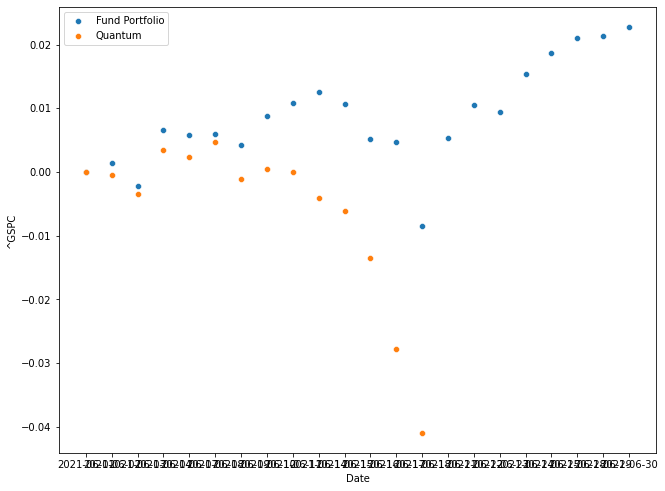


Run completed.

idx: 2021-06-21
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-21
self.position: 116
self.initial_position: 2021-06-14
sum price: 85348.36595726013
sum daily returns: -8.136293659568619
avg daily returns: 0.032028158231445
covariance_matrix sum: 38.223701493691564
correlation_matrix sum: 114927.06957342078
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 76
solution_stocks: {'A': 0, 'AAL': 0, 'AAP': 0, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABT': 0, 'ACGL': 116, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 37, 'ADP': 0, 'ADSK': 0, 'AEE': 0, 'AEP': 0, 'AES': 0, 'AFL': 0, 'AIG': 0, 'AIZ': 0, 'AJG': 0, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 0, 'ALLE': 0, 'AMAT': 0, 'AMCR': 111, 'AMD': 0, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 129, 'ANET': 0, 'ANSS': 0, 'AON': 164, 'AOS': 0, 'APA': 0, 'APD': 0, 'APH': 0, 'APTV': 0, 'ARE': 0, 'ATO': 0, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 0, 'AWK': 0, 'AXP': 0,

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423
0,2021-06-11,15347.22,-707.86,9.989337e+05,-0.000062
0,2021-06-14,9623.83,537.38,9.949905e+05,-0.004009


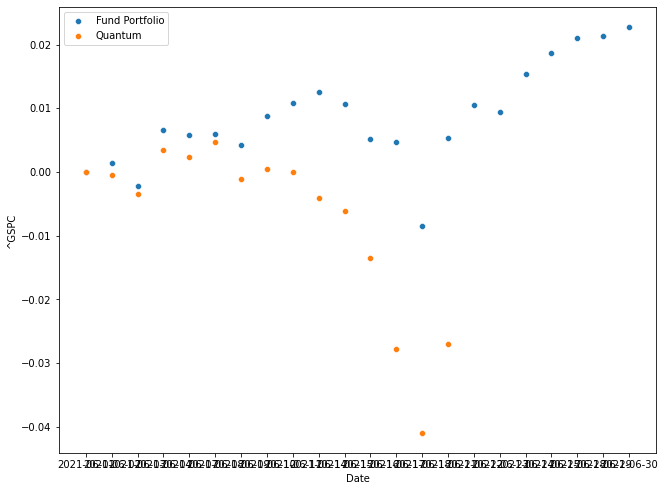


Run completed.

idx: 2021-06-22
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-22
self.position: 117
self.initial_position: 2021-06-15
sum price: 85675.53490543365
sum daily returns: -5.467358052883739
avg daily returns: -0.20707418484082796
covariance_matrix sum: 38.88916474087418
correlation_matrix sum: 119650.31238146282
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 75
solution_stocks: {'A': 0, 'AAL': 471, 'AAP': 0, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABT': 0, 'ACGL': 0, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 0, 'ADP': 0, 'ADSK': 0, 'AEE': 0, 'AEP': 0, 'AES': 0, 'AFL': 0, 'AIG': 25, 'AIZ': 0, 'AJG': 0, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 0, 'ALLE': 0, 'AMAT': 0, 'AMCR': 0, 'AMD': 0, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 0, 'ANSS': 0, 'AON': 0, 'AOS': 0, 'APA': 0, 'APD': 0, 'APH': 0, 'APTV': 0, 'ARE': 0, 'ATO': 0, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 0, 'AWK': 0, 'AXP': 0, 'AZ

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423
0,2021-06-11,15347.22,-707.86,9.989337e+05,-0.000062
0,2021-06-14,9623.83,537.38,9.949905e+05,-0.004009


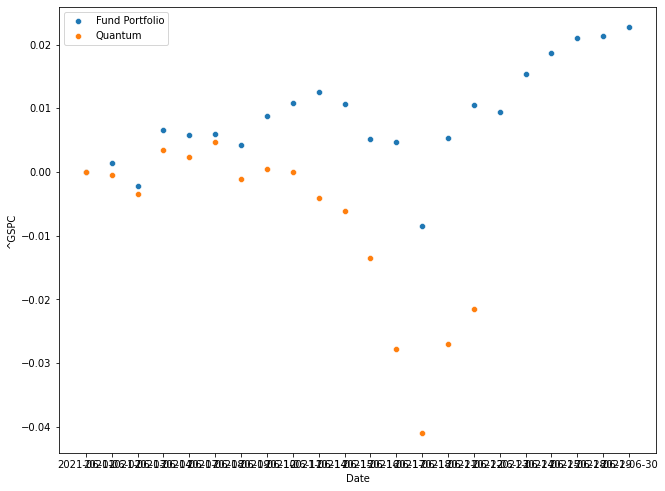


Run completed.

idx: 2021-06-23


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-23
self.position: 118
self.initial_position: 2021-06-16
sum price: 85530.61793899536
sum daily returns: -6.195730078315842
avg daily returns: -0.9270389340354698
covariance_matrix sum: 38.69662174581643
correlation_matrix sum: 121694.52760038782
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 88
solution_stocks: {'A': 0, 'AAL': 97, 'AAP': 0, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABT': 0, 'ACGL': 0, 'ACN': 0, 'ADBE': 142, 'ADI': 0, 'ADM': 0, 'ADP': 0, 'ADSK': 0, 'AEE': 0, 'AEP': 0, 'AES': 0, 'AFL': 0, 'AIG': 0, 'AIZ': 0, 'AJG': 0, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 40, 'ALL': 0, 'ALLE': 0, 'AMAT': 0, 'AMCR': 98, 'AMD': 165, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 0, 'ANSS': 0, 'AON': 44, 'AOS': 18, 'APA': 17, 'APD': 0, 'APH': 0, 'APTV': 0, 'ARE': 24, 'ATO': 0, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 0, 'AWK': 0, 'AXP': 0, 'AZO': 0, 'BA': 0, 'BAC': 0, 

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423
0,2021-06-11,15347.22,-707.86,9.989337e+05,-0.000062
0,2021-06-14,9623.83,537.38,9.949905e+05,-0.004009


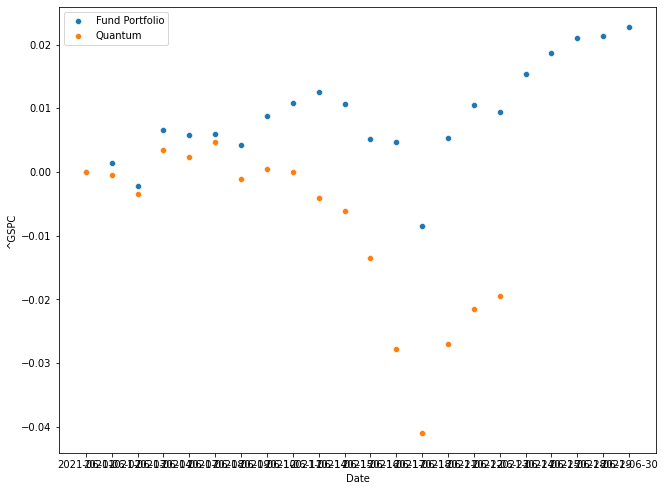


Run completed.

idx: 2021-06-24
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-24
self.position: 119
self.initial_position: 2021-06-17
sum price: 86064.66306877136
sum daily returns: 0.2825759484013304
avg daily returns: -0.7817523543795594
covariance_matrix sum: 40.005290967905054
correlation_matrix sum: 119728.11367568564
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 75
solution_stocks: {'A': 3, 'AAL': 165, 'AAP': 0, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABT': 20, 'ACGL': 0, 'ACN': 0, 'ADBE': 108, 'ADI': 0, 'ADM': 0, 'ADP': 0, 'ADSK': 0, 'AEE': 0, 'AEP': 0, 'AES': 53, 'AFL': 0, 'AIG': 0, 'AIZ': 20, 'AJG': 0, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 1, 'ALL': 0, 'ALLE': 0, 'AMAT': 0, 'AMCR': 375, 'AMD': 337, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 18, 'ANET': 0, 'ANSS': 0, 'AON': 168, 'AOS': 20, 'APA': 73, 'APD': 0, 'APH': 0, 'APTV': 0, 'ARE': 2, 'ATO': 0, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 0, 'AWK': 1, 

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423
0,2021-06-11,15347.22,-707.86,9.989337e+05,-0.000062
0,2021-06-14,9623.83,537.38,9.949905e+05,-0.004009


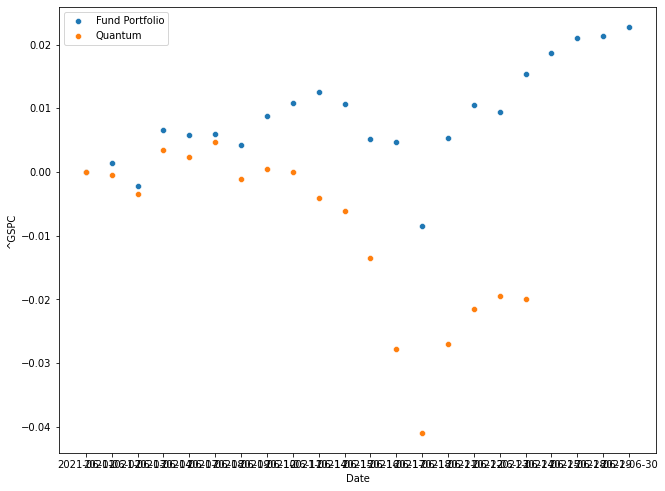


Run completed.

idx: 2021-06-25
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-25
self.position: 120
self.initial_position: 2021-06-18
sum price: 86605.62908935547
sum daily returns: 8.562716402262176
avg daily returns: 0.5252756837953919
covariance_matrix sum: 35.685846464394565
correlation_matrix sum: 139975.03610508924
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 75
solution_stocks: {'A': 3, 'AAL': 181, 'AAP': 0, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABT': 0, 'ACGL': 32, 'ACN': 0, 'ADBE': 150, 'ADI': 0, 'ADM': 0, 'ADP': 0, 'ADSK': 0, 'AEE': 14, 'AEP': 0, 'AES': 13, 'AFL': 0, 'AIG': 13, 'AIZ': 0, 'AJG': 0, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 1, 'ALL': 2, 'ALLE': 0, 'AMAT': 0, 'AMCR': 189, 'AMD': 72, 'AME': 7, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 4, 'ANET': 0, 'ANSS': 0, 'AON': 0, 'AOS': 0, 'APA': 73, 'APD': 0, 'APH': 1, 'APTV': 0, 'ARE': 2, 'ATO': 0, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 0, 'AWK': 0, 'AXP':

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423
0,2021-06-11,15347.22,-707.86,9.989337e+05,-0.000062
0,2021-06-14,9623.83,537.38,9.949905e+05,-0.004009


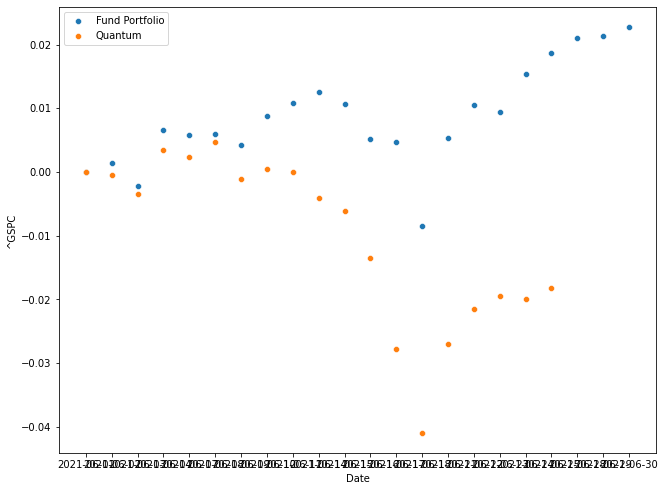


Run completed.

idx: 2021-06-28


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-28
self.position: 121
self.initial_position: 2021-06-21
sum price: 86654.15990829468
sum daily returns: 14.964845172777704
avg daily returns: -0.1846362023446213
covariance_matrix sum: 17.643521413150733
correlation_matrix sum: 93269.91062479127
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 75
solution_stocks: {'A': 9, 'AAL': 218, 'AAP': 0, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABT': 0, 'ACGL': 39, 'ACN': 0, 'ADBE': 0, 'ADI': 21, 'ADM': 0, 'ADP': 0, 'ADSK': 0, 'AEE': 5, 'AEP': 0, 'AES': 5, 'AFL': 90, 'AIG': 42, 'AIZ': 0, 'AJG': 0, 'AKAM': 0, 'ALB': 0, 'ALGN': 4, 'ALK': 0, 'ALL': 0, 'ALLE': 0, 'AMAT': 89, 'AMCR': 289, 'AMD': 409, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 97, 'ANET': 0, 'ANSS': 0, 'AON': 0, 'AOS': 0, 'APA': 42, 'APD': 0, 'APH': 3, 'APTV': 0, 'ARE': 0, 'ATO': 0, 'ATVI': 52, 'AVB': 0, 'AVGO': 14, 'AVY': 0, 'AWK': 0, 'AXP': 0, 'AZO': 0, 'BA': 91, 'BAC'

,idx,variance,returns,value,value_norm
0,2021-06-01,27.36,-343.86,9.989952e+05,0.000000
0,2021-06-02,188.31,-42.04,9.985177e+05,-0.000478
0,2021-06-03,147.44,1735.07,9.955784e+05,-0.003420
0,2021-06-04,68.51,-184.26,1.002529e+06,0.003537
0,2021-06-07,6152.57,2111.13,1.001365e+06,0.002373
0,2021-06-08,96.57,759.71,1.003728e+06,0.004738
0,2021-06-09,1347.81,1198.91,9.978336e+05,-0.001163
0,2021-06-10,53516.61,241.15,9.994176e+05,0.000423
0,2021-06-11,15347.22,-707.86,9.989337e+05,-0.000062
0,2021-06-14,9623.83,537.38,9.949905e+05,-0.004009


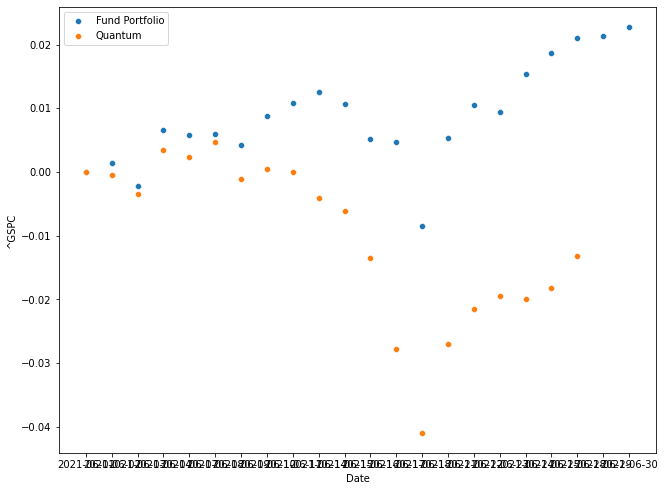


Run completed.

idx: 2021-06-29
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-29
self.position: 122
self.initial_position: 2021-06-22
sum price: 86794.4713382721
sum daily returns: 4.609732124055025
avg daily returns: -0.0118182167901566
covariance_matrix sum: 4.942105451124419
correlation_matrix sum: 40085.60263127622
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0


BufferError: ignored

In [9]:
print('initial df')
display(df.head())

# if not init_holdings_path: 
#     init_holdings_df, budget = generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget)
#     init_holdings_df.to_pickle(save_path+'init_holdings.pkl')
# else:
#     init_holdings_df = pd.read_pickle(init_holdings_path)
#     prices = df.loc[dates[0], :].values.tolist()
#     #print('init holdings df')
#     #display(init_holdings_df.head())
#     #print(f'prices: {prices}')
#     pop = init_holdings_df['b'].values.tolist()
#     #print(f'pop: {pop}')
#     budget = sum([d1 * d2 for d1, d2 in zip(prices, pop)])
#     print(f'GA budget: {budget}')

# init_holdings = {}
# for idx, row in init_holdings_df.iterrows():
#     init_holdings.update({row['a']: row['b']})
init_holdings = {s:0 for s in stocks}

#print(f'init_holdings: {init_holdings}')
#print(f'new budget: {budget}')
  
# checking if the directory demo_folder 
# exist or not.
if not os.path.exists(save_path+label):
    os.makedirs(save_path+label)

my_portfolio = MultiPeriod(data=df,
                        baseline=df_baseline,
                        budget=budget,
                        sampler_args=sampler_args,
                        dates=dates,
                        file_path=file_path,
                        model_type=model_type,
                        alpha=alpha,
                        verbose=verbose,
                        t_cost=t_cost,
                        label=label,
                        init_holdings=init_holdings,
                        save_path=save_path+label+'/'
                        )

my_portfolio.run(min_return=min_return, max_risk=max_risk, num=num)